In [16]:
import random

import numpy as np
import torch
from transformers import GPT2Tokenizer
from data.datasets.tokenized import TokenizedDataset

from models.from_scratch import TransformerShakespeare

In [17]:
# reproductibilidad

random.seed(42)

np.random.seed(42)

torch.manual_seed(42)

# Transformers for language generation

## The goal

## Language generation: write (sound like) as Shakespeare

Our goal is to write as Shakespeare, but off course this problem is very difficult so by now we are content to sound like Shakespeare 😅

## The dataset

To sound as Shakespeare we have a learning source: Measure for Measure, a play from William Shakespeare written in 1603, where the author
handle topics as morality, power and forgiveness.

## The model

On this project you will find two models for text generation:

- A transformers model built from zero
- A fine-tuned version of GPT2 ([OpenAI paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf))

## Tech stack

In order to solve the problem the next libraries are used:

1. Pytorch
2. Transformers, from hugging face
3. GTP causal model implementations and GTP tokenizers

## Project structure

This project involves an e2e deep learning task, from dataset processing, to model generation, so we dived the whole problem in various subfolders:

- **architecture**: Common machine learning artifacts and modules, like `SelfAttention` and other layer implementations
- **data**: All logic for load the input datasets and convert them into vectorized pairs `(x, y)`, using a tokenizer (seen later)
- **models**: The final architectures that learns how to generate text that sounds like Shakespeare using all **architecture** artifacts.
- **train**: The connector between datasets and models, there we handle all logic about model training and exports.

## The first thing: the dataset

As you may know, one of the most important parts of machine learning solutions is off course the data.

In order to sound like Shakespeare we have two main sources of information, extracted from the whole *Measure by Measure* play, its document has 40k lines.

- **data/static/train.txt**: The first 32k lines of *Measure by Measure* play
- **data/static/test.txt**: The last 8k lines of *Measure by Measure* play

As you can see at `data.datasets.tokenized` we implement all the logic to perform the next pipeline:

![Dataset pipeline](https://media.githubusercontent.com/media/lgemc/pytorch_training_course/refs/heads/master/static/data_pipeline.png)

## Batch size per words and tokens

As you may know, the tokenizer receives a max amount of words to be tokenized, its context length it is not unlimited,
so we should tokenize by chunks in order to get it working properly.

So we split the whole file into chunks of size 140 words.

We also use the same amount of tokens per pair x, y (x a batch of 140 tokens, y is x shifted to left with also 140 tokens)

## Synthethic dataset samples expantion

The whole dataset has got 202651 words, so we only can have 2026 samples for our model, in order to
increase this and to **has a more diverse dataset in a synthetic way** we generate some random indexes
to extract extra sequences from the dataset, additional to the original 2026 samples.

## Data tokenization

In order to convert the data into vectors we use the original `GTP2Tokenizer` which has a vocabulary of 50.257 tokens.

In [18]:
batch_size_words = 140
max_token_length = 140
amount_of_train_samples = 3000
amount_of_test_samples = 600

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
vocab_size = tokenizer.vocab_size

train_dataset  = TokenizedDataset(
    "../data/static/train.txt",
    tokenizer = tokenizer,
    batch_size_words = 140,
    max_token_length = 140,
    amount_of_samples = amount_of_train_samples,
)

test_dataset = TokenizedDataset(
    "../data/static/test.txt",
    tokenizer = tokenizer,
    batch_size_words = 140,
    max_token_length = 140,
    amount_of_samples = amount_of_test_samples,
)

print(f"Tran and test datasets loaded. Train len: {len(train_dataset)}, Test len {len(test_dataset)}")

Tran and test datasets loaded. Train len: 3000, Test len 600


## First use case: Lets train the model from zero

Text generation, so how?

We have a lot of ways to train a model for text generation, like `lstms`, `rnns`, `transformers`, and this time we are going to use `transformers`

Why transformers you may think, lets talk about some context:

### LSTMS and RNNS, strengths and weaknesses

As mentioned at [A Clockwork RNN](https://arxiv.org/pdf/1402.3511), Jan Koutnin et Al, RNNS have shown high accuracy on text based tasks, as mentioned in the paper on classification tasks and sequence generation tasks.

But this kind of networks has an important weakness: the required amount of time and computation power required for train this kind of networks.

Why? because the architecture is based on sequential gradient calculation to be transferred from layer to layer, so one gradient at time step ti can not
be calculated without the gradient at ti-i, so when we have high amounts of data, like wikipedia's whole dataset, resources needed exceeds the amount
of computation power available.

## Transformers: strengths and weaknesses

As shown in the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762) from Ashish Vaswani et al, transformer based models
for text tasks like text translation or generation can reach an accuracy near the state of the art at the time it was released (the accuracy is almost the same
or a little worse, +-0.2) but the training cost is one or two orders of magnitude less than those based on RNNS or convolutional neural network ones, like [Deep Recurrent Models with Fast-Forward Connections for Neural Machine
Translation](https://arxiv.org/pdf/1606.04199).

So off course transformers are an important topic, with strengths in accuracy but more importantly it reduces times and costs to train neural network models.

## Our first model to sound as Shakespeare: lets build from scratch

Our first model is a hand-made architecture based on transformers architecture proposed at **Attention is all you need** paper

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
block_size = max_token_length # it should match with the token length
model_dim = 64
heads_num = 8
blocks_num = 8
dropout = .1

model_from_scratch = TransformerShakespeare(
    vocab_size=vocab_size,
    block_size=block_size,
    model_dim=model_dim,
    heads_num=heads_num,
    blocks_num=blocks_num,
    device=device,
    dropout=dropout,
)
model_from_scratch

TransformerShakespeare(
  (E): Embedding(50257, 64)
  (posE): Embedding(140, 64)
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x SelfAttention(
            (Wq): Linear(in_features=64, out_features=8, bias=False)
            (Wk): Linear(in_features=64, out_features=8, bias=False)
            (Wv): Linear(in_features=64, out_features=8, bias=False)
          )
        )
        (dense): Linear(in_features=64, out_features=64, bias=False)
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffd): FeedForward(
        (dense1): Linear(in_features=64, out_features=256, bias=True)
        (dense2): Linear(in_features=256, out_features=64, bias=True)
      )
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (drop1): Dropout(p=0.3, inplace=False)
      (drop2): Dropout(p=0.3, inplace=False)
      (drop

In [21]:
from train.from_scratch import train as train_from_scratch

model_from_scratch, train_losses_from_scratch, test_losses_from_scratch =  train_from_scratch(
    model_from_scratch,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    epochs=2,
    batch_size=32,
    learning_rate=0.001,
    device=device,
    logging_steps=4,
    vocab_size=train_dataset.tokenizer.vocab_size
)

Epoch 1/2
Step 0, Loss: 11.055401802062988, Total steps: 94
Step 4, Loss: 10.49716567993164, Total steps: 94
Step 8, Loss: 10.054306983947754, Total steps: 94
Step 12, Loss: 9.73044204711914, Total steps: 94
Step 16, Loss: 9.361298561096191, Total steps: 94
Step 20, Loss: 9.058598518371582, Total steps: 94
Step 24, Loss: 8.66675853729248, Total steps: 94
Step 28, Loss: 8.37191104888916, Total steps: 94
Step 32, Loss: 7.9939069747924805, Total steps: 94
Step 36, Loss: 7.7170586585998535, Total steps: 94
Step 40, Loss: 7.544861793518066, Total steps: 94
Step 44, Loss: 7.322684288024902, Total steps: 94
Step 48, Loss: 7.123094081878662, Total steps: 94
Step 52, Loss: 6.838677883148193, Total steps: 94
Step 56, Loss: 6.8045654296875, Total steps: 94
Step 60, Loss: 6.787929534912109, Total steps: 94
Step 64, Loss: 6.608628749847412, Total steps: 94
Step 68, Loss: 6.628015995025635, Total steps: 94
Step 72, Loss: 6.560214042663574, Total steps: 94
Step 76, Loss: 6.586800575256348, Total step

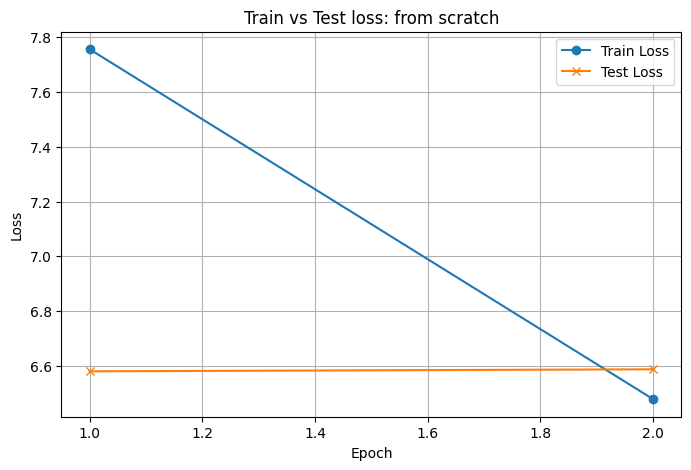

In [22]:
from train.generate import generate_text as generate_from_scratch
from graphs.lib import plot_losses

plot_losses(train_losses_from_scratch, test_losses_from_scratch, "Train vs Test loss: from scratch")

In [23]:
for i in range(0, 3):
    generated = generate_from_scratch(
        model=model_from_scratch,
        tokenizer=train_dataset.tokenizer,
        prompt="\n",
        max_new_tokens=250,
        temperature=0.8,
        top_p=0.95,
        device=device
    )
    print(f"Example model from scratch: {i}")
    print(generated)
    print("------------")

Example model from scratch: 0



., speak the,: in. when.

., so







; hath.; not like, it to
..I d that:,
 rest the, much, I,

 shall
 to
 for: was, their
By have; as: ofThe
 my
 the
 I be
, in,:

 of
oth

, not
 have, make to
: me: me was,

 you
Th:ES:, pardon

 and; young
 thou; to

:
er
 every,
 in to: me,
 should's,
I
,
 I
is,. be

, I d,,?:
;Th
 me! isO you



,L;The,And;
,
 with
's



: back
 you and
 the
 with.

Here,
 sovereign. and
. for it
 daughter
, myWARD
!
.?AMFor one:
 being

! then;
,As.,
!IO, to


 the
;,
------------
Example model from scratch: 1

 old

 in a.:RY,
.
:I
 everTh the
, you
 and as with by
 have in
,G the,ARD will: you

.AB
, what

,,,
 then
 of,We'dICH
: thisL

 herAnd
:

.ous
That

 and I in of love: notBeThe his you,
 of rather. by off the be,
 the

.
 to,,
, OF

? 'S
?
,And
:
 the,
 it
'll
 my? day,:,EN I:US
 shall,


HaveFirst this my all

,
 be. in I th!LE
,
: death sonUS
:: of I,'s:
,ly
:, again
OL:,. have
 and and love areButKE
ou

.,,
 any
 a

In [24]:
from models.fine_tune import GPTShakespeare
from transformers import GPT2Config
from train.finetuned import train as train_fine_tuned

model_fine_tuned = GPTShakespeare(
    GPT2Config(
        n_embd=140,
        n_head=4,
        n_layer=4,
        attn_pdrop=.7,
        embd_pdrop=.7,
        resid_pdrop=.7,
        summary_first_dropout=0.7
    ),
    vocab_size=train_dataset.tokenizer.vocab_size,
)

print(model_fine_tuned)

model_fine_tuned, train_losses_fine_tuned, test_losses_fine_tuned = train_fine_tuned(
    model_fine_tuned,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    epochs=2,
    batch_size=32,
    learning_rate=0.00001,
    device=device,
    logging_steps=4,
    vocab_size=train_dataset._vocab_size,
)

GPTShakespeare(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 140)
    (wpe): Embedding(1024, 140)
    (drop): Dropout(p=0.7, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((140,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=420, nx=140)
          (c_proj): Conv1D(nf=140, nx=140)
          (attn_dropout): Dropout(p=0.7, inplace=False)
          (resid_dropout): Dropout(p=0.7, inplace=False)
        )
        (ln_2): LayerNorm((140,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=560, nx=140)
          (c_proj): Conv1D(nf=140, nx=560)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.7, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((140,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=140, out_features=50257, bias=False)
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
   

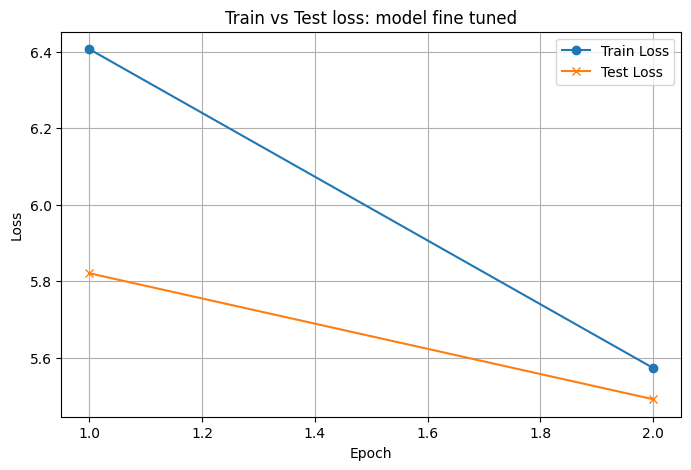

In [25]:
from train.generate_finetune import generate_text as generate_from_fine_tune
from graphs.lib import plot_losses

plot_losses(train_losses_fine_tuned, test_losses_fine_tuned, title="Train vs Test loss: model fine tuned")

In [26]:
for i in range(0, 3):
    generated = generate_from_fine_tune(
        model=model_fine_tuned,
        tokenizer=train_dataset.tokenizer,
        prompt="\n",
        max_new_tokens=250,
        temperature=0.8,
        top_p=0.95,
        device=device
    )
    print(f"Example model from finetune {i}")
    print(generated)
    print("------------")

Example model from finetune 0


AND
he is.

INGO
Come I,.
ELL
If with
l you are to you
 and may for
 yours with
 as
 you,,
 me the, you
 your will your me
 son by truth
 next two am
 not, between.Now,,,I.We are royal and.Are, our son
 own, that,,..'s
I, and, him. brother you;your, your
,,,'s? now, have the
 l;, my. we,,
, we,, in.,, me.
INGO
 the,,,,
 yours,
own own

 this. answer,

BYU
, both him your of., so your

 you?,,
 the son you

,.
INGO
 I this, the
, did leave
 and,, father your to
 areoth,f
 your and
 the, oath us
., therefore son
 we, of? some in
,,.s,
 you- to, of the
 of of, to: the, of us
 him,,
------------
Example model from finetune 1


DE:G

TH:That'll
 is by time
 years
 years and years
 are and yet's
 years and of twenty the!
T
ER:We;
, not, or again
 there is we wait
-well you're of,
 in old's know where'll in?
 then, you can then
 help to come
 you again if as out, thenceway
, till before
 is; now,, not I
 be?I?
;


ERIN:In,, back more.
:, thou,'t fall
, can't? t

## Conclussions

First, lets compare the validation losses for each model

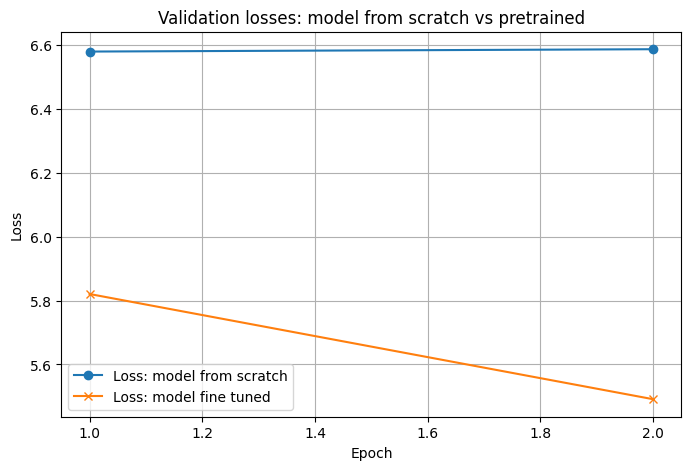

In [28]:
plot_losses(
    test_losses_from_scratch,
    test_losses_fine_tuned,
    "Validation losses: model from scratch vs pretrained",
    label1="Loss: model from scratch",
    label2="Loss: model fine tuned",
)